In [1]:
import requests
import importlib
import blizzard_api
import mysql
import mplusdb
import blizzard_credentials
import pandas as pd
import utils
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime
import sys

In [2]:
importlib.reload(mplusdb)
mdb = mplusdb.MplusDatabase('.db_config')
realms = mdb.get_utility_table('realm')
dungeons = mdb.get_utility_table('dungeon')
specs = mdb.get_utility_table('spec')

In [3]:
realm_clusters = realms[['cluster_id', 'region']].drop_duplicates()

In [4]:
auth = blizzard_credentials.Credentials('.api_tokens')
access_token = auth.access_token

In [5]:
# this is a bit anti-pattern, but the fastest way

# generate url calls for every valid combination of
# region/realm_cluster/dungeon/period

# S4 starts with period 734
region_encoder = {1:'us', 2:'kr', 3:'eu', 4:'tw'}

all_urls = []
urls_for_period_region_dungeon = {}
for _, row in dungeons.iterrows():
    dungeon_id = row[0]
    if dungeon_id < 244:
        continue;
    period_start = 734 #row[2]
    period_end = 763
    for _, realm in realm_clusters.iterrows():
        cluster_id = realm[0]
        region = region_encoder[realm[1]]
        url_factory = blizzard_api.UrlFactory(
            access_token = access_token, region=region)
        for period in range(period_start, period_end+1):
            url = url_factory.get_mythic_plus_leaderboard_url(
                dungeon_id = dungeon_id, realm_id = cluster_id,
                period = period)
            all_urls.append(url)
            #assign url to a sub-list by region-period
            key = (region, period, dungeon_id)
            if key in urls_for_period_region_dungeon:
                urls_for_period_region_dungeon[key].append(url)
            else:
                urls_for_period_region_dungeon[key] = []
                urls_for_period_region_dungeon[key].append(url)

In [6]:
len(urls_for_period_region_dungeon)

1440

In [7]:
# check math by hand
calls_per_realm = (10 * (764-662)) + (33 * 2)
print('calls per realm', calls_per_realm)
print('total calls', calls_per_realm * len(realm_clusters))

calls per realm 1086
total calls 275844


In [8]:
print('total time (hrs):', len(all_urls) * 0.25 / 3600)
print('total space raw json (Gbs):', 1/1024 * 1.2 * len(all_urls))
print('total space python list (Gbs):', 1/1024 * 0.02 * len(all_urls))

total time (hrs): 6.35
total space raw json (Gbs): 107.15625
total space python list (Gbs): 1.7859375


#### How are we going to do this?

So we got 284,000 url calls we need to make. Each call takes on ~0.25 seconds on average (if we use 10 threads), and generates 1.2Mb of data.

```
Total data size = 273,304 * 1.2Mb = 320 Gb
```

The capacity of my DB is just 20Gb. Oh-oh. I don't even have the storage for this.

#### Is it really 1.2Mb per call? I don't think so:

The raw json is 1.2Mb. Once we extract the data, the list is only 20kb. So total is:

```
Total data size = 273,304 * 0.02Mb = 5 Gb
```

I have plenty of space for this. Yay. Let's proceed.

#### This is how we are going to proceed:
* Break up the API calls into segments based on region and time period. Each segment is a time period within a region, and there are 404 total segments.
* Query each segment, one at a time.
* Aggregate data for each segment, and push to DB
* Keep track of which segment is done using some form of logging

In [9]:
import datetime


class MyLogger():
    """wrapper for a simple logger"""
    __fp = 'logs/mdb_segments.log'
    def __init__(self):
        pass
    
    def log(self, segment_id):
        ts = time.time()
        ts = datetime.datetime.fromtimestamp(ts).strftime('%c')
        with open(self.__fp, 'a') as file:
            #file.write('%s\t%s\t%s\t%s\n' % (ts, segment_id))
            file.write('%s\t%s\n' % (ts, segment_id))
            
    def get_logged_keys(self):
        keys = []
        with open(self.__fp, 'r') as file:
            for line in file:
                key_token = line.split()[-1]
                key = key_token.split('_')
                keys.append((key[0], int(key[1]), int(key[2])))
        return keys

In [10]:
logger = MyLogger()
logged_keys = logger.get_logged_keys()
print(len(logged_keys))

1145


In [11]:
1/(87.0/1440)

16.551724137931036

In [12]:
def divide_chunks(list_, n): 
    # looping till length l 
    for i in range(0, len(list_), n):  
        yield list_[i:i + n] 
        
list(divide_chunks(list(range(10)), 11))

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]

In [14]:
importlib.reload(blizzard_api)
importlib.reload(mplusdb)

def divide_chunks(list_, n): 
    # looping till length l 
    for i in range(0, len(list_), n):  
        yield list_[i:i + n] 
        
        
def api_call(url):
    time.sleep(0.1)
    try:
        response = requests.get(url, timeout = 10)
    except:
        response = requests.get(url)
    #print(time.time())
    #response = 0
    return response

def api_call_session(urls):
    responses = []
    with requests.Session() as session:
        for url in urls:
            try:
                response = session.get(url, timeout = 10)
            except: 
                response = session.get(url, timeout = 10)
            responses.append(response)
    return responses

def multi_threaded_call_chunked(urls):
    """Sends multiple calls to the API at once."""
    
    #chunk the urls into pieces with 10 urls each
    url_chunks = divide_chunks(urls, 10)
        
    threads = []
    with ThreadPoolExecutor(max_workers = 10) as executor:
        for chunk in url_chunks:
            threads.append(executor.submit(api_call_session, chunk))
    agg_result = []
    for task in as_completed(threads):
        agg_result.extend(task.result())
    return agg_result
    

def multi_threaded_call(urls):
    """Sends multiple calls to the API at once."""
    threads = []
    with ThreadPoolExecutor(max_workers = 10) as executor:
        for url in urls:
            threads.append(executor.submit(api_call, url))
    agg_result = []
    for task in as_completed(threads):
        agg_result.append(task.result())
    return agg_result


def agg_leaderboards(responses):
    """Joins output of several leaderboards into single list."""
    parser = blizzard_api.ResponseParser()
    
    runs = []
    comps = []
    rosters = []
            
    for resp in responses:
        try:
            leaderboard = parser.parse_keyrun_leaderboard_json(resp.json())
            runs.extend(leaderboard.get_runs_as_tuple_list())
            rosters.extend(leaderboard.get_rosters_as_tuple_list())
            comps.extend(leaderboard.get_run_comps_as_vector_list())
        except:
            print(resp.status_code)
            xx
    return runs, comps, rosters

mdb = mplusdb.MplusDatabase('.db_config')

segment = []
t0 = time.time()
i = 0

logger = MyLogger()
logged_keys = logger.get_logged_keys() # segments already done

for key, urls in urls_for_period_region_dungeon.items():
    if key in logged_keys:
        i += 1
        print(key, i)
        continue
    print(key)
    print(len(urls))
    print(datetime.datetime.now())
    t00 = time.time()
    responses = None
    #responses = multi_threaded_call(urls)
    responses = multi_threaded_call_chunked(urls)
    t1 = time.time()
    print('api calls', t1 - t00)
    runs, comps, rosters = agg_leaderboards(responses)
    t2 = time.time()
    print('parsing jsons', t2 - t1)
    runs = list(set(runs))
    rosters = list(set(rosters))
    comps = list(set(comps))
    t3 = time.time()
    print('set(data)', t3 - t2)
    
    
    
    comps = sorted(comps, key = lambda x: x[0])
    rosters = sorted(rosters, key = lambda x: x[0])
    
    mdb.insert(table = 'run', data = runs)
    t4 = time.time()
    print('inserting runs', t4 - t3)
    
    mdb.insert(table = 'roster', data = rosters)
    t5 = time.time()
    print('inserting rosters', t5 - t4)
    
    mdb.insert(table = 'run_composition', data = comps)
    t5 = time.time()
    print('inserting comps', t5 - t4)
    
    print(len(runs))
    print(len(comps))
    print(len(rosters))
    i += 1
    logger.log('%s_%s_%s' % key)
    print('-------------------')
    if i % 10 == 0:
        time.sleep(2)
    if i == 1500:
        break
print('total', time.time() - t0)

('us', 734, 244) 1
('us', 735, 244) 2
('us', 736, 244) 3
('us', 737, 244) 4
('us', 738, 244) 5
('us', 739, 244) 6
('us', 740, 244) 7
('us', 741, 244) 8
('us', 742, 244) 9
('us', 743, 244) 10
('us', 744, 244) 11
('us', 745, 244) 12
('us', 746, 244) 13
('us', 747, 244) 14
('us', 748, 244) 15
('us', 749, 244) 16
('us', 750, 244) 17
('us', 751, 244) 18
('us', 752, 244) 19
('us', 753, 244) 20
('us', 754, 244) 21
('us', 755, 244) 22
('us', 756, 244) 23
('us', 757, 244) 24
('us', 758, 244) 25
('us', 759, 244) 26
('us', 760, 244) 27
('us', 761, 244) 28
('us', 762, 244) 29
('us', 763, 244) 30
('kr', 734, 244) 31
('kr', 735, 244) 32
('kr', 736, 244) 33
('kr', 737, 244) 34
('kr', 738, 244) 35
('kr', 739, 244) 36
('kr', 740, 244) 37
('kr', 741, 244) 38
('kr', 742, 244) 39
('kr', 743, 244) 40
('kr', 744, 244) 41
('kr', 745, 244) 42
('kr', 746, 244) 43
('kr', 747, 244) 44
('kr', 748, 244) 45
('kr', 749, 244) 46
('kr', 750, 244) 47
('kr', 751, 244) 48
('kr', 752, 244) 49
('kr', 753, 244) 50
('kr', 75

('kr', 749, 369) 1246
('kr', 750, 369) 1247
('kr', 751, 369) 1248
('kr', 752, 369) 1249
('kr', 753, 369) 1250
('kr', 754, 369) 1251
('kr', 755, 369) 1252
('kr', 756, 369) 1253
('kr', 757, 369) 1254
('kr', 758, 369) 1255
('kr', 759, 369) 1256
('kr', 760, 369) 1257
('kr', 761, 369) 1258
('kr', 762, 369) 1259
('kr', 763, 369) 1260
('eu', 734, 369) 1261
('eu', 735, 369) 1262
('eu', 736, 369) 1263
('eu', 737, 369) 1264
('eu', 738, 369) 1265
('eu', 739, 369) 1266
('eu', 740, 369)
121
2020-08-22 23:33:27.717445
api calls 43.28181481361389
parsing jsons 4.342776536941528
set(data) 0.14773035049438477
inserting runs 6.454683542251587
inserting rosters 71.69056272506714
inserting comps 82.34529733657837
27482
27480
137393
-------------------
('eu', 741, 369)
121
2020-08-22 23:35:44.291136
api calls 38.757732629776
parsing jsons 4.26549220085144
set(data) 0.15322017669677734
inserting runs 19.45291256904602
inserting rosters 70.07698774337769
inserting comps 80.32362365722656
25493
25492
127459
-

inserting rosters 6.29012131690979
inserting comps 7.779598951339722
1562
1562
7810
-------------------
('tw', 738, 369)
9
2020-08-23 00:50:09.462365
api calls 27.664663314819336
parsing jsons 0.35619425773620605
set(data) 0.013956069946289062
inserting runs 1.5788607597351074
inserting rosters 19.535812377929688
inserting comps 21.779784202575684
1941
1941
9705
-------------------
('tw', 739, 369)
9
2020-08-23 00:51:00.856960
api calls 15.026114702224731
parsing jsons 0.3976109027862549
set(data) 0.014189720153808594
inserting runs 7.005283832550049
inserting rosters 6.793776035308838
inserting comps 9.4417245388031
1917
1917
9585
-------------------
('tw', 740, 369)
9
2020-08-23 00:51:32.743018
api calls 23.755374670028687
parsing jsons 0.35811424255371094
set(data) 0.014305353164672852
inserting runs 1.8495042324066162
inserting rosters 7.75122594833374
inserting comps 10.159528732299805
2013
2013
10065
-------------------
('tw', 741, 369)
9
2020-08-23 00:52:08.881440
api calls 25.9

api calls 11.337008953094482
parsing jsons 2.661379814147949
set(data) 0.08969426155090332
inserting runs 7.421350002288818
inserting rosters 72.23770546913147
inserting comps 80.94914174079895
17347
17345
86723
-------------------
('us', 738, 370)
115
2020-08-23 01:14:34.102562
api calls 13.121245384216309
parsing jsons 2.839160919189453
set(data) 0.1003732681274414
inserting runs 8.088951587677002
inserting rosters 55.75369095802307
inserting comps 65.72296905517578
18827
18826
94126
-------------------
('us', 739, 370)
115
2020-08-23 01:16:03.976461
api calls 14.993962526321411
parsing jsons 2.8827905654907227
set(data) 0.0999612808227539
inserting runs 8.941953897476196
inserting rosters 75.83400201797485
inserting comps 85.30239582061768
18068
18064
90318
-------------------
('us', 740, 370)
115
2020-08-23 01:17:56.198643
api calls 17.432883739471436
parsing jsons 3.159609317779541
set(data) 0.10588693618774414
inserting runs 8.733438491821289
inserting rosters 93.73373913764954
i

parsing jsons 0.3610076904296875
set(data) 0.010358810424804688
inserting runs 12.811000108718872
inserting rosters 9.969454765319824
inserting comps 12.678882122039795
2687
2687
13435
-------------------
('kr', 737, 370)
9
2020-08-23 02:23:05.923176
api calls 12.117015838623047
parsing jsons 0.340822696685791
set(data) 0.009490013122558594
inserting runs 3.126307487487793
inserting rosters 9.267550230026245
inserting comps 11.24312949180603
2566
2566
12830
-------------------
('kr', 738, 370)
9
2020-08-23 02:23:32.761186
api calls 12.880667924880981
parsing jsons 0.4120762348175049
set(data) 0.010165929794311523
inserting runs 17.866358041763306
inserting rosters 10.598269939422607
inserting comps 13.32082200050354
2703
2703
13515
-------------------
('kr', 739, 370)
9
2020-08-23 02:24:17.252931
api calls 39.509809255599976
parsing jsons 0.3759634494781494
set(data) 0.009751319885253906
inserting runs 2.8775508403778076
inserting rosters 9.616393804550171
inserting comps 11.2052569389

inserting rosters 79.0399980545044
inserting comps 101.50089931488037
28110
28109
140542
-------------------
('eu', 736, 370)
121
2020-08-23 02:49:25.043420
api calls 40.63864755630493
parsing jsons 4.211695432662964
set(data) 0.13894033432006836
inserting runs 9.135589361190796
inserting rosters 96.09383296966553
inserting comps 108.02226114273071
29296
29295
146470
-------------------
('eu', 737, 370)
121
2020-08-23 02:52:07.192485
api calls 39.79545545578003
parsing jsons 4.059656143188477
set(data) 0.14020752906799316
inserting runs 9.368581771850586
inserting rosters 98.51106238365173
inserting comps 109.05325770378113
26831
26828
134134
-------------------
('eu', 738, 370)
121
2020-08-23 02:54:49.610879
api calls 42.55010008811951
parsing jsons 4.3306825160980225
set(data) 0.14827942848205566
inserting runs 9.236644744873047
inserting rosters 130.51867747306824
inserting comps 174.71376705169678
29375
29371
146852
-------------------
('eu', 739, 370)
121
2020-08-23 02:58:40.59202

inserting comps 35.70818829536438
1435
1435
7175
-------------------
('tw', 735, 370)
9
2020-08-23 04:25:57.485706
api calls 34.729283809661865
parsing jsons 0.33319759368896484
set(data) 0.011314153671264648
inserting runs 1.4620673656463623
inserting rosters 7.657020568847656
inserting comps 9.914580583572388
1646
1646
8230
-------------------
('tw', 736, 370)
9
2020-08-23 04:26:43.937699
api calls 39.44589042663574
parsing jsons 0.4234013557434082
set(data) 0.011356115341186523
inserting runs 2.2820773124694824
inserting rosters 7.352596282958984
inserting comps 10.040332078933716
2018
2018
10090
-------------------
('tw', 737, 370)
9
2020-08-23 04:27:36.142039
api calls 42.081971168518066
parsing jsons 0.3736598491668701
set(data) 0.01164555549621582
inserting runs 3.296907663345337
inserting rosters 5.93780779838562
inserting comps 8.687360525131226
1777
1777
8885
-------------------
('tw', 738, 370)
9
2020-08-23 04:28:30.595707
api calls 31.190518379211426
parsing jsons 0.4415471

In [17]:
#JSONDecodeError: Expecting value: line 1 column 1 (char 0)
# 105 - 116 || 20k
# 142 - 157 || 25k
# 46  - 56  || 24k
# 82  - 93  || 27k

In [ ]:
test_rq.json()

In [ ]:
1.5*1440/60

In [ ]:
importlib.reload(utils)
importlib.reload(blizzard_api)
all_urls[0]

t0 = time.time()
test_rq = requests.get(all_urls[0])
print(time.time() - t0)
test_klb = blizzard_api.KeyRunLeaderboard(test_rq.json())

In [ ]:
test_klb.keyruns[0].get_composition_vector()
t0 = time.time()
comps = test_klb.get_run_comps_as_vector_list()
print(time.time()-t0)
print(comps)

In [ ]:
tuple([1,2])

In [ ]:
print(len(set(comps)))

In [ ]:
#import pickle
#pickle.dump(leaderboard.get_runs_as_tuple_list(), open('test_objs.pkl', 'wb'))
#print(leaderboard.keyruns)

In [15]:
period = [734, 552152,
735, 573429,
736, 600545,
737, 533797,
738, 600092,
739, 574013,
740, 632797,
741, 566984,
742, 530253,
743, 602726,
744, 619092,
745, 675847,
746, 664888,
747, 687195,
748, 715860,
749, 621633,
750, 734762,
751, 750325,
752, 718098,
753, 695534,
754, 693893,
755, 629968,
756, 607517,
757, 627584,
758, 601825,
759, 551282,
760, 606719,
761, 565799,
762, 604201,
763, 496264]


In [18]:
per = [i for i in period if i < 800]
pop = [i for i in period if i > 100000]

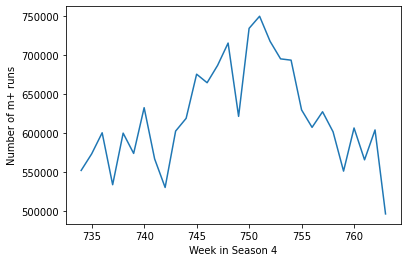

In [22]:
fig = plt.figure()
plt.plot(per, pop)
plt.xlabel('Week in Season 4')
plt.ylabel('Number of m+ runs')
plt.show()